In [1]:
import pandas as pd
import numpy as np
import dill
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
DATASET_PATH = './/car_price_prediction.csv'
PREPARED_DATASET_PATH = './/car_price_prediction_prepared.csv'

### Загружаем датасет:

In [3]:
df = pd.read_csv(DATASET_PATH)
df.head(3)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2


In [4]:
df.rename(columns={'Engine volume': 'Engine_volume'}, inplace=True)
df.rename(columns={'Prod. year': 'Prod_year'}, inplace=True)
df.rename(columns={'Leather interior': 'Leather_interior'}, inplace=True)
df.rename(columns={'Fuel type': 'Fuel_type'}, inplace=True)
df.rename(columns={'Gear box type': 'Gear_box_type'}, inplace=True)
df.rename(columns={'Drive wheels': 'Drive_wheels'}, inplace=True)

### Отсутствующие значения не обнаружены.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod_year         19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather_interior  19237 non-null  object 
 8   Fuel_type         19237 non-null  object 
 9   Engine_volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear_box_type     19237 non-null  object 
 13  Drive_wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

### Отбор признаков:

In [6]:
num = ['Engine_volume', 'Mileage', 'Doors', 'Prod_year', 'Cylinders', 'Airbags']
cat = ["Category",'Leather_interior','Fuel_type', 'Gear_box_type', 'Drive_wheels','Wheel','Color']
target = ['Price']

In [7]:
df = df[num+cat+target]
df.head(3)

,Engine_volume,Mileage,Doors,Prod_year,Cylinders,Airbags,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels,Wheel,Color,Price
0,3.5,186005 km,04-May,2010,6.0,12,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,Silver,13328
1,3,192000 km,04-May,2011,6.0,8,Jeep,No,Petrol,Tiptronic,4x4,Left wheel,Black,16621
2,1.3,200000 km,04-May,2006,4.0,2,Hatchback,No,Petrol,Variator,Front,Right-hand drive,Black,8467


### Преобразование признаков в удобный формат:

In [8]:
for i in df['Engine_volume']:
    if i.endswith("Turbo"):
        df.loc[df['Engine_volume'] == i, 'Engine_volume'] = i[:-6]
    
df['Engine_volume'] = pd.to_numeric(df['Engine_volume'])

In [9]:
df['Mileage'] = df['Mileage'].str[:-3]
df['Mileage'] = pd.to_numeric(df['Mileage'])

In [10]:
df['Doors'].replace({"04-May":4}, inplace = True)
df['Doors'].replace({"02-Mar":2}, inplace = True)
df['Doors'].replace({">5":5}, inplace = True)

In [11]:
df.head(3)

,Engine_volume,Mileage,Doors,Prod_year,Cylinders,Airbags,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels,Wheel,Color,Price
0,3.5,186005,4,2010,6.0,12,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,Silver,13328
1,3.0,192000,4,2011,6.0,8,Jeep,No,Petrol,Tiptronic,4x4,Left wheel,Black,16621
2,1.3,200000,4,2006,4.0,2,Hatchback,No,Petrol,Variator,Front,Right-hand drive,Black,8467


### Обзор признаков с выбросами:

array([[<AxesSubplot:title={'center':'Engine_volume'}>,
        <AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Doors'}>],
       [<AxesSubplot:title={'center':'Prod_year'}>,
        <AxesSubplot:title={'center':'Cylinders'}>,
        <AxesSubplot:title={'center':'Airbags'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

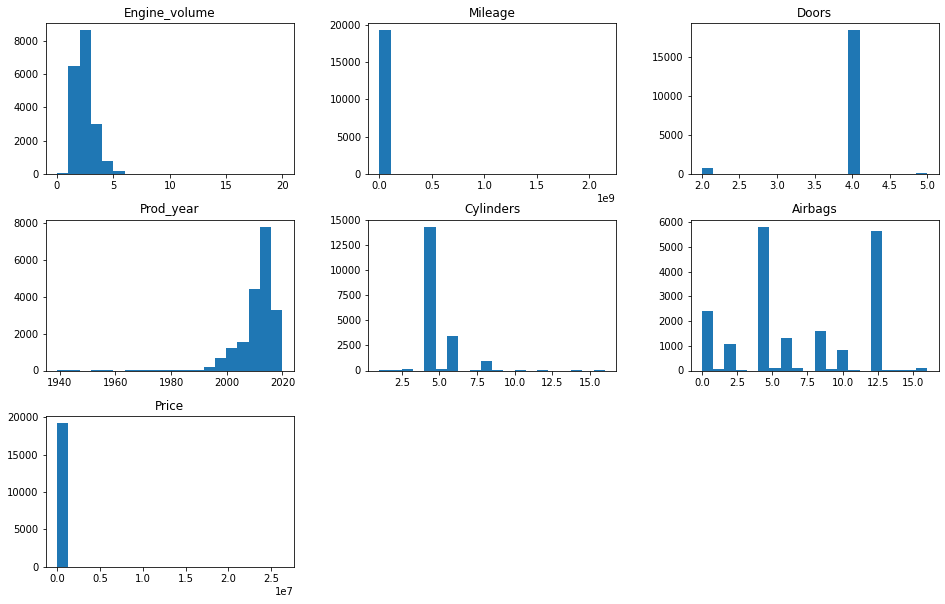

In [12]:
dftr_num_features = df[num+target]
dftr_num_features.hist(figsize=(16,10), bins=20, grid=False)

### Устранение выбросов:

In [13]:
df.loc[df['Engine_volume'] > 8, 'Engine_volume'] = round(df['Engine_volume'].mean(),2)
df.loc[df['Engine_volume'] == 0, 'Engine_volume'] = round(df['Engine_volume'].std(),2)

In [14]:
df.loc[df['Mileage'] > 350000, 'Mileage'] = 150000

In [15]:
df['Price'].iloc[1225] = (df['Price'].iloc[1225])/10
df['Price'].iloc[8541] = (df['Price'].iloc[1225])/10
df['Price'].iloc[16983] = (df['Price'].iloc[16983])/10000

In [16]:
df['Mileage'].describe()

count     19237.000000
mean     128920.460519
std       78264.114756
min           0.000000
25%       70139.000000
50%      126000.000000
75%      176480.000000
max      350000.000000
Name: Mileage, dtype: float64

<AxesSubplot:>

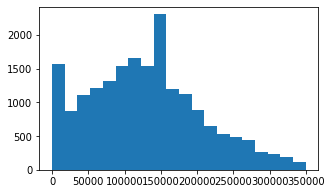

In [17]:
df['Mileage'].hist(figsize=(5,3), bins=20, grid=False)

<Figure size 1080x216 with 0 Axes>

<AxesSubplot:xlabel='Mileage'>

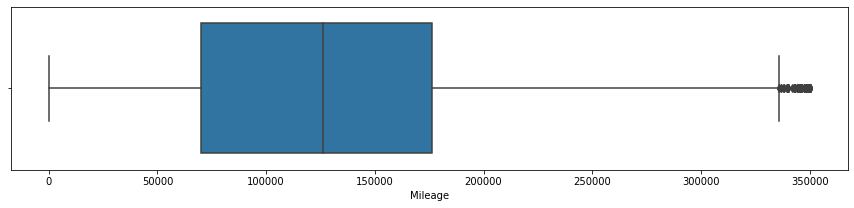

In [18]:
plt.figure(figsize=(15, 3))
sns.boxplot(df['Mileage'])
plt.show()

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

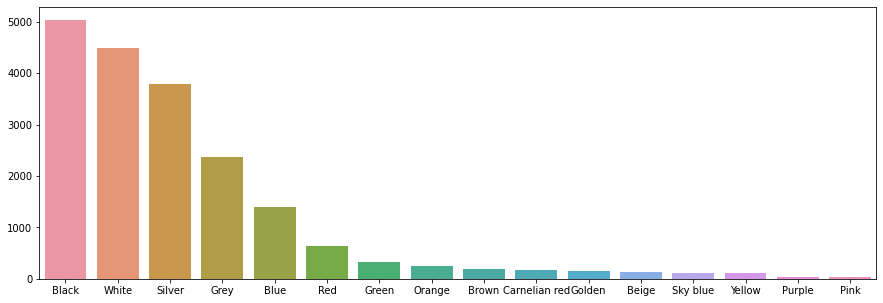

In [19]:
countsTR = df['Color'].value_counts()
plt.figure(figsize=(15,5))    
sns.barplot(countsTR.index, countsTR.values)
plt.show()

### Обзор признаков без выбросов:

array([[<AxesSubplot:title={'center':'Engine_volume'}>,
        <AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Doors'}>],
       [<AxesSubplot:title={'center':'Prod_year'}>,
        <AxesSubplot:title={'center':'Cylinders'}>,
        <AxesSubplot:title={'center':'Airbags'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

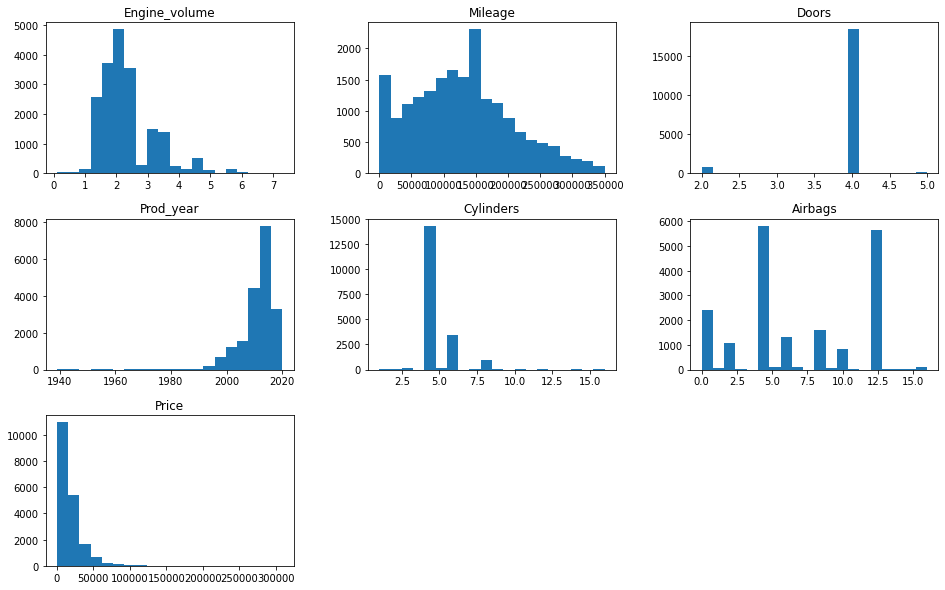

In [20]:
dftr_num_features = df[num+target]
dftr_num_features.hist(figsize=(16,10), bins=20, grid=False)

### Матрица корреляций:

<Figure size 576x216 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation matrix')

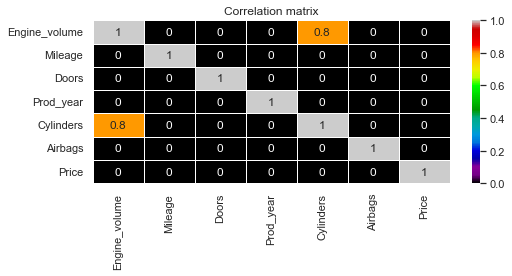

In [21]:
plt.figure(figsize = (8,3))

sns.set(font_scale=1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='nipy_spectral')

plt.title('Correlation matrix')
plt.show()

### Как видно из графика, сильно коррелируют между собой только два признака. Остальные не корреляруются вообще.

### Сохранение исправленного датасета:

In [22]:
df.to_csv(PREPARED_DATASET_PATH, index=False)

### Загрузка обработанного татасета для последующего обучения модели:

In [23]:
df = pd.read_csv(PREPARED_DATASET_PATH)

In [24]:
df.head()

,Engine_volume,Mileage,Doors,Prod_year,Cylinders,Airbags,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels,Wheel,Color,Price
0,3.5,186005,4,2010,6.0,12,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,Silver,13328.0
1,3.0,192000,4,2011,6.0,8,Jeep,No,Petrol,Tiptronic,4x4,Left wheel,Black,16621.0
2,1.3,200000,4,2006,4.0,2,Hatchback,No,Petrol,Variator,Front,Right-hand drive,Black,8467.0
3,2.5,168966,4,2011,4.0,0,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,White,3607.0
4,1.3,91901,4,2014,4.0,4,Hatchback,Yes,Petrol,Automatic,Front,Left wheel,Silver,11726.0


In [25]:
df.head()

,Engine_volume,Mileage,Doors,Prod_year,Cylinders,Airbags,Category,Leather_interior,Fuel_type,Gear_box_type,Drive_wheels,Wheel,Color,Price
0,3.5,186005,4,2010,6.0,12,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,Silver,13328.0
1,3.0,192000,4,2011,6.0,8,Jeep,No,Petrol,Tiptronic,4x4,Left wheel,Black,16621.0
2,1.3,200000,4,2006,4.0,2,Hatchback,No,Petrol,Variator,Front,Right-hand drive,Black,8467.0
3,2.5,168966,4,2011,4.0,0,Jeep,Yes,Hybrid,Automatic,4x4,Left wheel,White,3607.0
4,1.3,91901,4,2014,4.0,4,Hatchback,Yes,Petrol,Automatic,Front,Left wheel,Silver,11726.0


### Разбиение датасета и сохранение выборок на диск:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[num+cat], df[target], random_state=12)

In [27]:
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

### Pipeline:

In [28]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [29]:
cat_transformers = []
num_transformers = []

for cat_col in cat:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col)),
                #('standard', MinMaxScaler())
                ('standard', StandardScaler())
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for num_col in (num):
    num_transformer = Pipeline([
                ('selector', NumberSelector(key=num_col)),
                #('standard', MinMaxScaler())
                ('standard', StandardScaler())
            ])
    num_transformers.append((num_col, num_transformer))

In [30]:
feats = FeatureUnion(num_transformers+cat_transformers)
feature_processing = Pipeline([('feats', feats)])

### Выбор и обучение модели:

In [31]:
pipeline = Pipeline([('features',feats), 
                     ('reg', DecisionTreeRegressor(max_depth = 40, 
                                                   min_samples_split = 30, 
                                                   min_samples_leaf = 10, 
                                                   max_features = 'auto', 
                                                   random_state=12, 
                                                   max_leaf_nodes = 100))])

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Engine_volume',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Engine_volume')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Mileage',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Mileage')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Doors',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Doors')),
                                                                 ('stand...
                                                                  FeatureSelector(column='Wheel')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Wheel')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Color',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Color')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Color')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('reg',
                 DecisionTreeRegressor(max_depth=40, max_features='auto',
                                       max_leaf_nodes=100, min_samples_leaf=10,
                                       min_samples_split=30,
                                       random_state=12))])

### Сохранение модели:

In [33]:
with open("DTreeReg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)